In [50]:
import numpy as np
import os
from os.path import join, isfile
from PIL import Image
import torch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Change directory to the data directory from hw1
os.chdir(r"C:\Users\aksha\OneDrive\Desktop\Desktop\Spring 2023\Estimation Detection and Learning\Final Project\Disparity_Map")
half_path = r"C:\Users\aksha\OneDrive\Desktop\Desktop\Spring 2023\Estimation Detection and Learning\Final Project\Disparity_Map"
count = 0
train_x_im = []
dir_list = os.listdir('.')
train_labels = []
label_count = 0
# Open all the images from the files list for both train and test data and append to a large tensor
# Normalize the data so it is easier to process
for folder in dir_list:
    full_path = half_path + "\\" + folder
    os.chdir(full_path)
    for file in os.listdir('.'):
        with Image.open(file) as img:
            img = img.resize((300, 300))
            img_data = np.asarray(img)
            img_data = img_data.astype(np.float32) # / 255.0
            img_tensor = torch.from_numpy(img_data).float()
            train_x_im.append(img_tensor)
        train_labels.append(label_count)
    label_count = label_count + 1
train_x = torch.stack(train_x_im)
print(np.shape(train_x))
print(np.shape(train_labels))
# Rearange tensor
#train_shuf, labels_shuf = shuffle(train_x, train_labels, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_labels, test_size=0.33, random_state=42)

torch.Size([11177, 300, 300])
(11177,)


In [51]:
X_train = X_train.unsqueeze(0)
X_test = X_test.unsqueeze(0)
X_train = X_train.permute(1, 0, 2, 3)
X_test = X_test.permute(1, 0, 2, 3)
print(np.shape(X_train))

torch.Size([7488, 1, 300, 300])


In [52]:
# Create a tensor for the labels as well
y_train = np.array(y_train)
y_train = y_train.astype(int)
y_test = np.array(y_test)
y_test = y_test.astype(int)
train_label = torch.tensor(y_train).long()
test_label = torch.tensor(y_test).long()

In [53]:
import torch.nn as nn
# Create CNN model with various layers. Apply pooling and RELU
# Make sure to set the linear layers correctly
class Conv2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1,20,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(20,64,5),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
            nn.Conv2d(64,64,7),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
            
            nn.Flatten(),
            #nn.Linear(3136,6000),
            #nn.ReLU(),
            nn.Linear(3136,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,5)
        )
    
    def forward(self, x):
        return self.network(x)

model = Conv2D()

In [54]:
# Create your train and test datasets with labels
batch_size = 200
train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_train,train_label),
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_test,test_label),
                                           batch_size=batch_size,
                                           shuffle=True)
 
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
num_epochs = 10
train_loss_tot = []
train_acc_tot = []
test_loss_tot = []
test_acc_tot = []
 
# Loop through the number of epochs
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0
 
    # set model to train mode
    model.train()
    # iterate over the training data
    for inputs, labels in train_loader:
        #inputs = inputs.reshape(batch_size,1,300,300)
        optimizer.zero_grad()
        outputs = model(inputs)
        #compute the loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # increment the running loss and accuracy
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item()
 
    # calculate the average training loss and accuracy
    train_loss /= len(train_loader)
    train_loss_tot.append(train_loss)
    train_acc /= len(train_loader.dataset)
    train_acc_tot.append(train_acc)
 
    # set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            #inputs = inputs.reshape(batch_size,1,300,300) 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).sum().item()
 
    # calculate the average validation loss and accuracy
    test_loss /= len(test_loader)
    test_loss_tot.append(test_loss)
    test_acc /= len(test_loader.dataset)
    test_acc_tot.append(test_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')

Epoch 1/10, train loss: 2.8057, train acc: 0.5486, test loss: 0.6218, test acc: 0.7314
Epoch 2/10, train loss: 0.5261, train acc: 0.7684, test loss: 0.3585, test acc: 0.8458
Epoch 3/10, train loss: 0.2903, train acc: 0.8831, test loss: 0.2869, test acc: 0.8927
Epoch 4/10, train loss: 0.1701, train acc: 0.9314, test loss: 0.2387, test acc: 0.9076
Epoch 5/10, train loss: 0.0954, train acc: 0.9619, test loss: 0.2450, test acc: 0.9146
Epoch 6/10, train loss: 0.0712, train acc: 0.9718, test loss: 0.2957, test acc: 0.9043
Epoch 7/10, train loss: 0.0695, train acc: 0.9770, test loss: 0.2553, test acc: 0.9236
Epoch 8/10, train loss: 0.0425, train acc: 0.9829, test loss: 0.2371, test acc: 0.9339
Epoch 9/10, train loss: 0.0170, train acc: 0.9945, test loss: 0.2170, test acc: 0.9485
Epoch 10/10, train loss: 0.0059, train acc: 0.9980, test loss: 0.2117, test acc: 0.9461


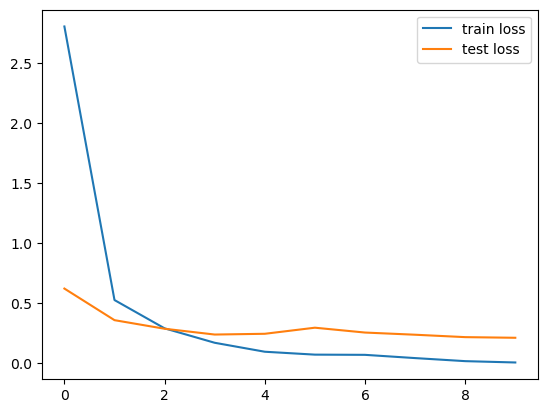

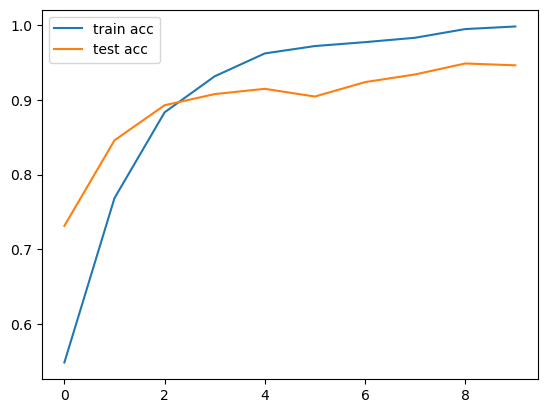

In [56]:
import matplotlib.pyplot as plt
 
# Plot the training and validation loss
plt.plot(train_loss_tot, label='train loss')
plt.plot(test_loss_tot, label='test loss')
plt.legend()
plt.show()
 
# Plot the training and validation accuracy
plt.plot(train_acc_tot, label='train acc')
plt.plot(test_acc_tot, label='test acc')
plt.legend()
plt.show()

In [59]:
# import the opencv library
import cv2
import os
vid = cv2.VideoCapture(0)
path = 'C:/Users/aksha/OneDrive/Desktop/Desktop/Spring 2023/Estimation Detection and Learning/Final Project/Test_Results/'
sub_list = os.listdir(path)
sub_list = [int(i) for i in sub_list]
# Create new test folder if it does not exist
if len(sub_list) == 0:
    new_dir_path = os.path.join(path, str(1))
    os.mkdir(new_dir_path)
else:
    new_folder = max(sub_list) + 1
    new_dir_path = os.path.join(path, str(new_folder))
    os.mkdir(new_dir_path)
# Change directory to new test folder to save image frames in
count = 0  
os.chdir(new_dir_path)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=9)
model.eval()
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    cv2.imwrite('Frame'+str(count)+'.jpg', frame)

    if count >= 5:
        path1 = new_dir_path + '/Frame' + str(count-5)
        path2 = new_dir_path + '/Frame' + str(count)
        img1 = cv2.imread(path1 + '.jpg')
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.imread(path2 + '.jpg')
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        disparity = stereo.compute(gray1,gray2)
        img_data = cv2.resize(disparity, (300, 300))
        img_data = np.asarray(img_data)
        img_data = img_data.astype(np.float32) # / 255.0
        img_tensor = torch.from_numpy(img_data).float()
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.unsqueeze(0)
        #img_tensor = img_tensor.permute(1, 0, 2, 3)
        outputs = model(img_tensor)
        class_out = outputs.argmax(1)
        if class_out == 0:
            out = 'Backward'
        elif class_out == 1:
            out = 'Standstill'
        elif class_out == 2:
            out = 'Left'
        elif class_out == 3:
            out = 'Right'
        elif class_out == 4:
            out = 'Forward'
        cv2.putText(frame, out, (320,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        cv2.imshow('frame', frame)
    count = count + 1
    
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()


In [17]:
img1 = cv2.imread(path1 + '.jpg')
print(path1)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)


C:/Users/aksha/OneDrive/Desktop/Desktop/Spring 2023/Estimation Detection and Learning/Final Project/Test_Results/8/Frame0
